In [27]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
import glob
import sys
from tqdm import tqdm
from scipy import signal
import pandas as pd

In [93]:
def measure_shock_single (filename_2d, margin, dvel_threshold, plot=False):
    
    if plot:
        plt.figure(figsize=(8,4))
        gs = GridSpec(2,2)
    
    # load the snapshot
    with open(filename_2d, 'rb') as f:
        data = pkl.load(f)[0]

    # basic properties
    dx = data['x1v'][1] - data['x1v'][0]
    middle = len(data['x1v']) // 2
    idx_margin = int(margin / dx)

    # find the shock front by local extrema of dvx/dx
    vel = data['vel1'][:,(middle-idx_margin):(middle+idx_margin)]
    dvel = signal.convolve2d(vel, [[-1,1]], mode='valid')
    xavg = 0.5*(data['x1v'][(middle-idx_margin+1):(middle+idx_margin)] + data['x1v'][(middle-idx_margin):(middle+idx_margin-1)])

    shock_y, shock_x = list(map(np.array, np.where(np.abs(dvel) > dvel_threshold)))
    df_shocks = pd.DataFrame(data=np.transpose((shock_y, shock_x)), columns=('shock_y', 'shock_x'))

    # limit shock_x to two values -- for the left and right shock
    shock_xl = df_shocks[df_shocks.shock_x < idx_margin].groupby('shock_y').mean().to_numpy()
    shock_xr = df_shocks[df_shocks.shock_x > idx_margin].groupby('shock_y').mean().to_numpy()
    del df_shocks
    shock_y = np.arange(len(data['x2v']))

    if plot:
        plt.subplot(gs[0,0])
        plt.plot(xavg, dvel[10,:])
        plt.xlim(-margin,margin)

        plt.subplot(gs[0,1])
        plt.contourf(xavg, data['x2v'], dvel, 64)
        plt.scatter(
            [xavg[x] for x in shock_xl.astype(int)],
            [data['x2v'][y] for y in shock_y.astype(int)],
            color='r', s=0.05
        )
        plt.scatter(
            [xavg[x] for x in shock_xr.astype(int)],
            [data['x2v'][y] for y in shock_y.astype(int)],
            color='r', s=0.05
        )

    # calculate the shock centroid
    shock_x = 0.5 * (shock_xl + shock_xr)

    # plot
    if plot:
        plt.scatter(
            [xavg[x] for x in shock_x.astype(int)],
            [data['x2v'][y] for y in shock_y.astype(int)],
            color='g', s=0.05
        )
        plt.xlim(-1,1)

        # calculate corrugation resolution
        plt.subplot(gs[1,:])
    n, bins, patches = plt.hist(shock_x, idx_margin // 4)

    bins = 0.5*(bins[1:] + bins[:-1])
    shock_x = bins[np.where(n > np.mean(n))[0]]
    shock_edges = np.min(shock_x), np.max(shock_x)

    for e in shock_edges:
        plt.axvline(e, color='r')

    shock_width = shock_edges[1] - shock_edges[0]

    if plot:
        print(f' - shock width is {shock_width:.1f}', flush=True)
        plt.show()
    plt.close()
    
    return shock_width

def measure_shocks (suite,
                    amplitudes=(1,2,5,10,20,50,75,100),
                    all_2d=False,
                    margin=1.0, # how far from the center do we expect the shock
                    dvel_threshold=0.1,
                    shell_width=1.0, dt=0.1,
                    time_factor=(1.0,2.0)
    ):
    
    amplitudes_here = []
    shock_widths = []
    
    for ampl in amplitudes:

        print(f'Amplitude: {ampl}', flush=True)

        plt.figure(figsize=(8,2))
        gs = GridSpec(1,2)

        # first, find the collision time using 1D data

        rhomax = []
        rho_prev = np.inf; i_start = 0
        for i in tqdm(range(len(os.listdir(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/results_corr0ampl{ampl}/joined_vtk')))):
            with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/results_corr0ampl{ampl}/joined_vtk/IntSh2-p1.{i:04d}.vtk.pkl', 'rb') as f:
                data = pkl.load(f)[0]
            rho = np.max(data['rho'])
            if rho > rho_prev: # ignore the initial decompression
                rhomax.append(rho)
                rho_prev = -np.inf
                if not i_start: i_start = i
            else:
                rho_prev = rho
                continue
            del data

        i_coll = np.argmax(rhomax)+i_start
        print(f' - maximum shock compression at i = {i_coll}', flush=True)
        di = (np.array(time_factor) * shell_width / dt).astype(int)
        print(f' - corrugation should be measured for i within {i_coll - di[0]} -- {i_coll + di[1]}')

        plt.subplot(gs[0,0])
        plt.plot(range(len(rhomax)), rhomax)
        plt.axvline(i_coll-i_start, color='r')

        with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/results_corr0ampl{ampl}/joined_vtk/IntSh2-p1.{i_coll:04d}.vtk.pkl', 'rb') as f:
            data = pkl.load(f)[0]
        rho = np.max(data['rho'])

        plt.subplot(gs[0,1])
        plt.contourf(data['x1v'], data['x2v'], data['rho'], 64)
        plt.xlim(-1,1)
        
        plt.show(); plt.close()

        # then, fine-tune on 2D data ------------------------------------------
        if all_2d:
            filenames_2d = [f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/results_corr1ampl{ampl}/joined_vtk/IntSh2-p1.{i:04d}.vtk.pkl' for i in range(i_coll-di[0], i_coll+di[1]+1)]
        else:
            filenames_2d = [f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/{suite}/prod1_corr_ampl/results_corr1ampl{ampl}/joined_vtk/IntSh2-p1.{i_coll:04d}.vtk.pkl']
        
        margin = 1.0 # how far from the center do we expect the shock
        dvel_threshold = 0.1
        rhomax = []
        rho_prev = np.inf; i_start = 0

        shock_widths_here = []
        frames_here = []
        for i,filename_2d in tqdm(enumerate(filenames_2d), total=len(filenames_2d)):
            try:
                shock_width = measure_shock_single(
                    filename_2d,
                    margin=margin,
                    dvel_threshold=dvel_threshold,
                    plot=False
                )
                frames_here.append(i)
                shock_widths_here.append(shock_width)

            except FileNotFoundError:
                plt.close()
                print(' - 2D snapshot not found. Continuing.', flush=True)
            
        if len(frames_here) > 0:
            plt.plot(frames_here, shock_widths_here)
            plt.ylabel('Shock width [px]')
            plt.xlabel('2D snapshot no.')
            plt.show(); plt.close()

            shock_width_idx = np.argmax(shock_widths_here)
            shock_width = measure_shock_single(
                    filenames_2d[shock_width_idx],
                    margin=margin,
                    dvel_threshold=dvel_threshold,
                    plot=True
                )

            shock_widths.append(shock_width)
            amplitudes_here.append(ampl)
        
    plt.plot(amplitudes_here, shock_widths)
    plt.xlabel('Amplitude')
    plt.ylabel('Shock width [px]')
    plt.show(); plt.close()

    print('Done.', flush=True)

Amplitude: 1


100%|██████████| 201/201 [00:00<00:00, 1070.64it/s]

 - maximum shock compression at i = 47
 - corrugation should be measured for i within 37 -- 67


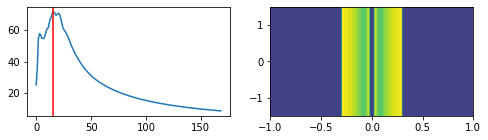

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


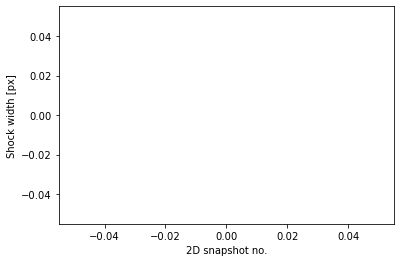

 - shock width is 0.0


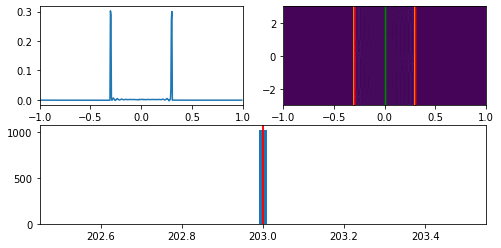

Amplitude: 2


100%|██████████| 201/201 [00:00<00:00, 1113.98it/s]

 - maximum shock compression at i = 47
 - corrugation should be measured for i within 37 -- 67


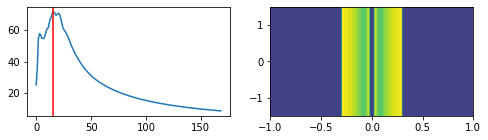

  0%|          | 0/1 [00:00<?, ?it/s]

 - 2D snapshot not found. Continuing.


100%|██████████| 1/1 [00:00<00:00, 1717.57it/s]

Amplitude: 5



100%|██████████| 201/201 [00:00<00:00, 986.38it/s] 

 - maximum shock compression at i = 47


 - corrugation should be measured for i within 37 -- 67


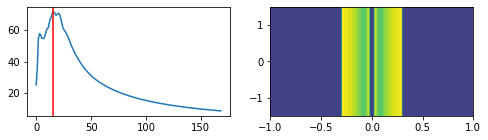

  0%|          | 0/1 [00:00<?, ?it/s]

 - 2D snapshot not found. Continuing.


100%|██████████| 1/1 [00:00<00:00, 1429.06it/s]

Amplitude: 10



100%|██████████| 201/201 [00:00<00:00, 967.25it/s]

 - maximum shock compression at i = 47


 - corrugation should be measured for i within 37 -- 67


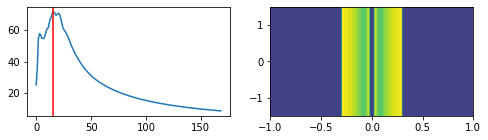

  0%|          | 0/1 [00:00<?, ?it/s]

 - 2D snapshot not found. Continuing.


100%|██████████| 1/1 [00:00<00:00, 1552.30it/s]

Amplitude: 20



100%|██████████| 201/201 [00:00<00:00, 319.05it/s]

 - maximum shock compression at i = 47


 - corrugation should be measured for i within 37 -- 67


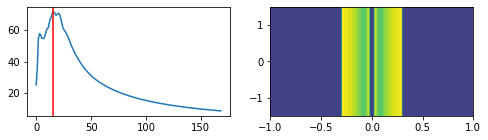

100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


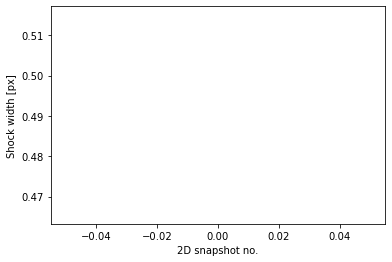

 - shock width is 0.5


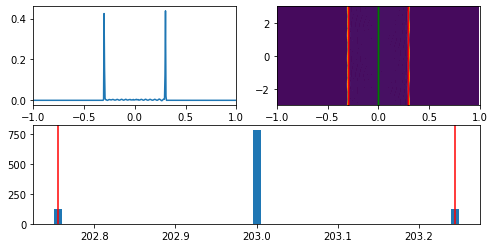

Amplitude: 50


100%|██████████| 201/201 [00:00<00:00, 278.16it/s]

 - maximum shock compression at i = 47


 - corrugation should be measured for i within 37 -- 67


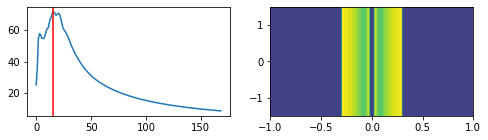

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


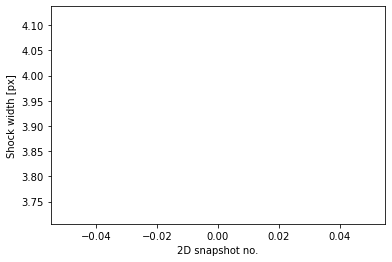

 - shock width is 3.9


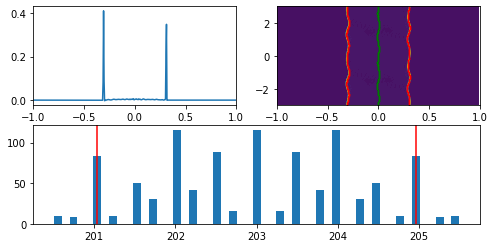

Amplitude: 75


100%|██████████| 201/201 [00:00<00:00, 814.93it/s]

 - maximum shock compression at i = 47


 - corrugation should be measured for i within 37 -- 67


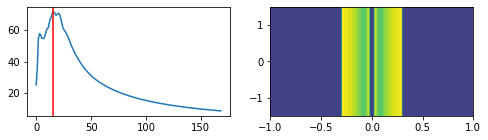

  0%|          | 0/1 [00:00<?, ?it/s]

 - 2D snapshot not found. Continuing.


100%|██████████| 1/1 [00:00<00:00, 1741.82it/s]

Amplitude: 100



100%|██████████| 201/201 [00:00<00:00, 539.32it/s]

 - maximum shock compression at i = 47


 - corrugation should be measured for i within 37 -- 67


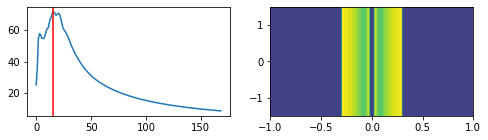

  0%|          | 0/1 [00:00<?, ?it/s]

 - 2D snapshot not found. Continuing.


100%|██████████| 1/1 [00:00<00:00, 1636.48it/s]


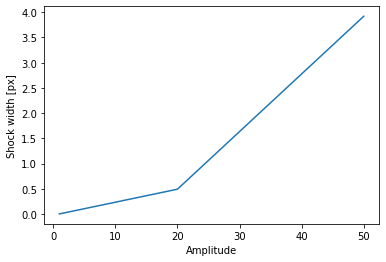

Done.


In [94]:
measure_shocks('corrT2_press', all_2d=False)

Amplitude: 1


100%|██████████| 201/201 [00:00<00:00, 281.22it/s]

 - maximum shock compression at i = 52


 - shock width is 14.8


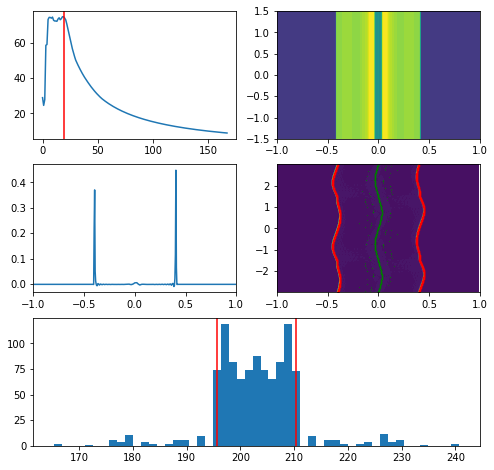

Amplitude: 2


100%|██████████| 201/201 [00:00<00:00, 252.38it/s]

 - maximum shock compression at i = 42


 - shock width is 42.0


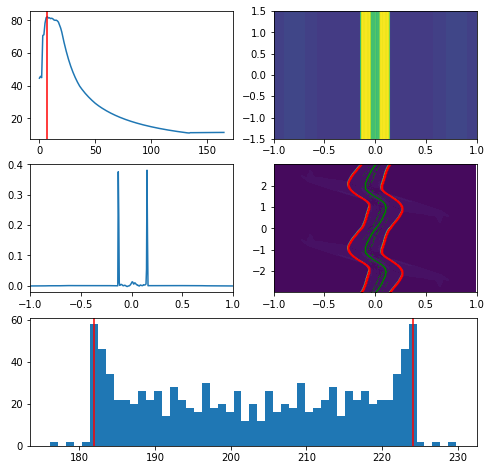

Amplitude: 5


100%|██████████| 201/201 [00:00<00:00, 264.29it/s]

 - maximum shock compression at i = 38


 - shock width is 66.7


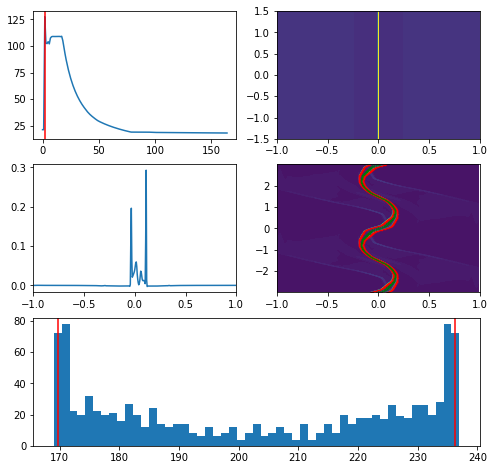

Amplitude: 10


100%|██████████| 201/201 [00:00<00:00, 283.04it/s]

 - maximum shock compression at i = 44


 - shock width is 79.4


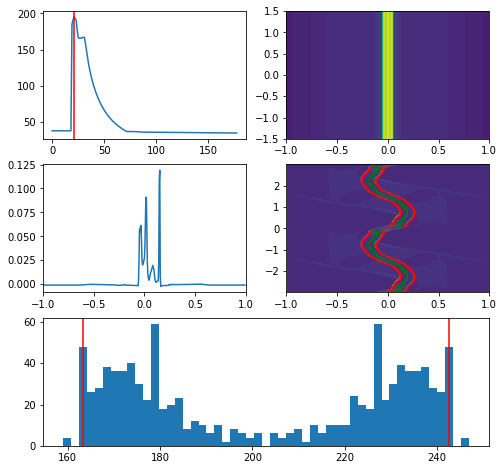

Amplitude: 20


100%|██████████| 201/201 [00:00<00:00, 253.20it/s]

 - maximum shock compression at i = 49


 - shock width is 92.9


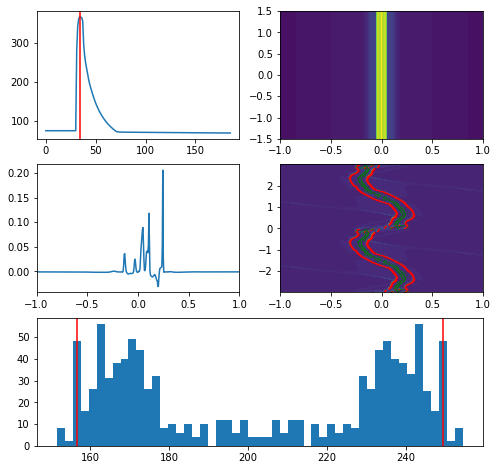

Amplitude: 50


100%|██████████| 201/201 [00:00<00:00, 272.90it/s]

 - maximum shock compression at i = 58


 - shock width is 108.7


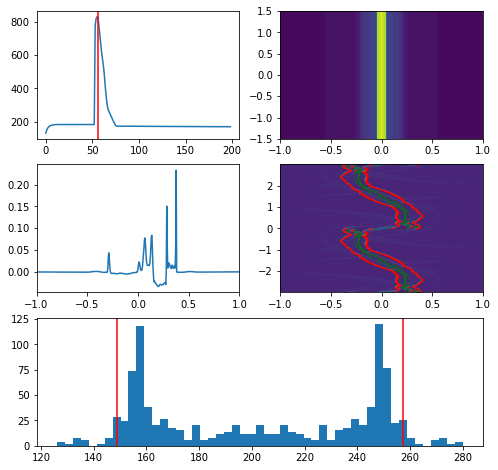

Amplitude: 75


100%|██████████| 201/201 [00:00<00:00, 270.39it/s]

 - maximum shock compression at i = 61


 - shock width is 125.5


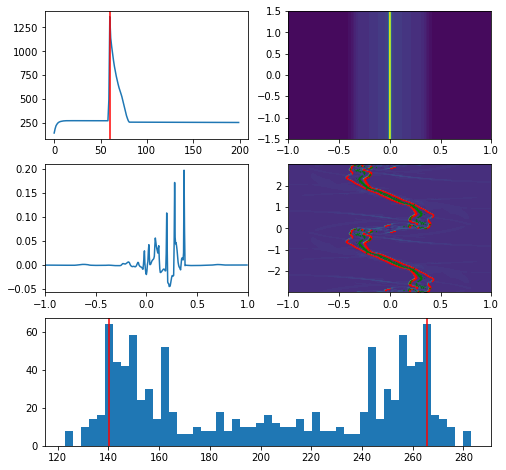

Amplitude: 100


100%|██████████| 201/201 [00:00<00:00, 274.23it/s]

 - maximum shock compression at i = 65


 - shock width is 134.1


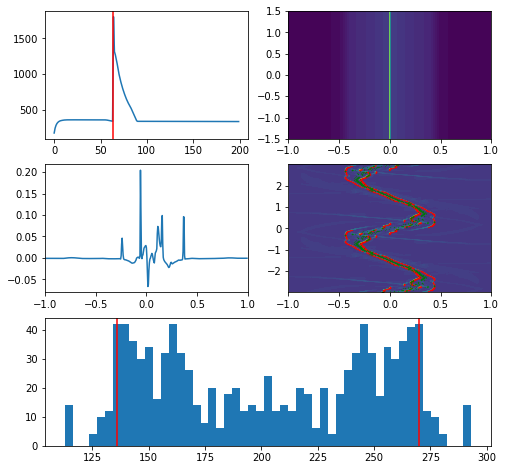

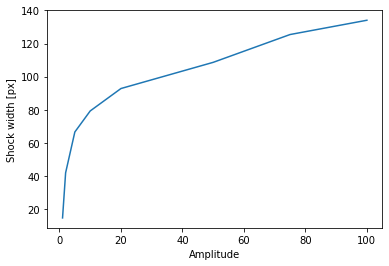

Done.


In [48]:
measure_shocks('corrT1_dens')

100%|██████████| 201/201 [00:00<00:00, 1114.78it/s]


Maximum shock compression at i = 48


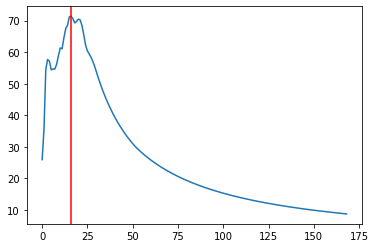

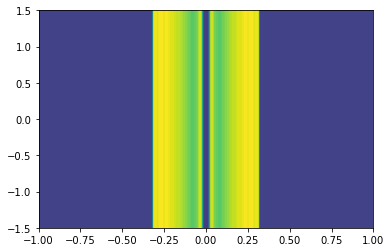

In [55]:
measure_shocks('corrT3_vel')